# IE4211 Project AY22/23 Semester 2 - Group 15

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

## Preprocessing

### Data cleaning
First, we need to clean the data of any NA values.

In [3]:
train = pd.read_csv('Data-train.csv', index_col=0)
test = pd.read_csv('Data-test.csv', index_col=0)

In [4]:
print(train.isna().sum().sum())
print(test.isna().sum().sum())

0
0


Fortunately, the dataset is already clean.

### Visualization
Let's visualize the labels to see if there are any outliers. We'll use a boxplot to visualize the distribution of the labels.

In [5]:
X_train = train.drop('sales', axis=1)
y_train = train['sales']

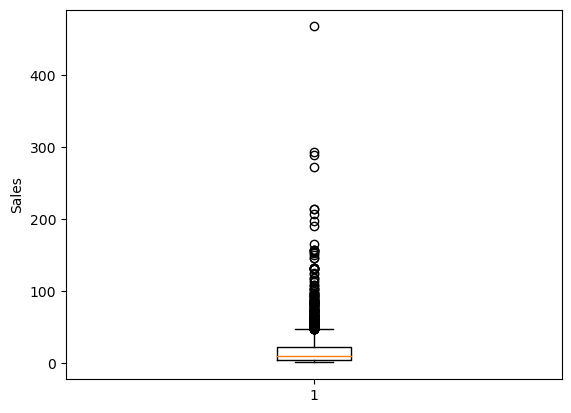

In [6]:
plt.boxplot(y_train)
plt.ylabel('Sales')
plt.show()

Since there is a considerable number of outliers, we need to deal with them. There are multiple ways to deal with outliers, but here we'll just log transform so that the label range decreases.

In [7]:
y_train_log = np.log(y_train)

Let's visualize the distributions of y and y_log using histograms.

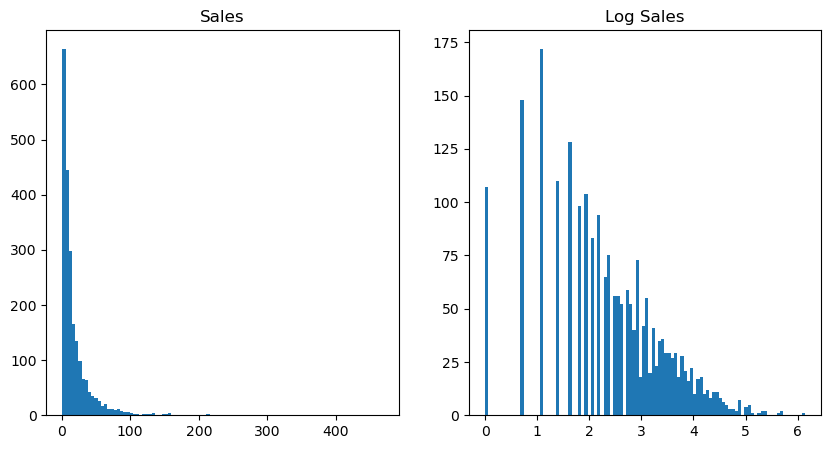

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(y_train, bins=100)
ax[0].set_title('Sales')
ax[1].hist(y_train_log, bins=100)
ax[1].set_title('Log Sales')
plt.show()

Distribution of y_log is not as skewed as y. Therefore, predicting on y_log should be more accurate. However, this is just theory and we'll test with both y and y_log.

### Feature engineering
From the project description, there are some categorical variables that we need to deal with. First, let's check whether any of the 4 undescribed attributes is categorical.

In [9]:
train.nunique()

productID                 75
brandID                   31
attribute1                 3
attribute2                 7
attribute3                31
attribute4              2211
clickVolume             1096
avgOriginalUnitPrice     346
avgFinalUnitPrice       1791
ma14SalesVolume          658
weekday                    7
meanAge                  613
gender                   298
meanEducation            341
maritalStatus            284
plus                     304
meanPurchasePower        292
meanUserLevel            564
meanCityLevel            403
sales                    126
dtype: int64

In [10]:
test.nunique()

productID                 75
brandID                   31
attribute1                 3
attribute2                 7
attribute3                30
attribute4              1475
clickVolume              879
avgOriginalUnitPrice     242
avgFinalUnitPrice       1243
ma14SalesVolume          554
weekday                    7
meanAge                  461
gender                   228
meanEducation            266
maritalStatus            233
plus                     231
meanPurchasePower        226
meanUserLevel            423
meanCityLevel            326
dtype: int64

`attribute1`, `attribute2` and `attribute3` are categorical, along with `productID`, `brandID` and `weekday`. One-hot encoding will be performed on these columns. As usual, we'll drop the first column to avoid the dummy variable trap and combine train and test data before one-hot encoding. 

In [11]:
categorical_cols = ['productID', 'brandID', 'attribute1', 'attribute2', 'attribute3', 'weekday']

In [12]:
combined = pd.concat([X_train, test])
combined = pd.get_dummies(combined, columns=categorical_cols, drop_first=True)

In [13]:
combined.shape

(3686, 165)

In this project, we shall also explore the effect of standardization on the model performance.

In [14]:
non_standardized_X_train = combined.iloc[:X_train.shape[0]]
non_standardized_X_test = combined.iloc[X_train.shape[0]:]

In [15]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler(with_mean=False)

In [16]:
combined_stan = ss.fit_transform(combined)
combined_stan = pd.DataFrame(combined_stan, columns=combined.columns)

In [17]:
standardized_X_train = combined_stan.iloc[:X_train.shape[0]]
standardized_X_test = combined_stan.iloc[X_train.shape[0]:]
standardized_X_test.index = test.index

## Model selection
In this step, we'll perform 10-fold cross-validation on some models that we searched for best parameters. All 4 configurations will be considered, that is y, y_log, y and y_log with standardization.

Following models will be examined in this notebook: Gradient Boosting, Random Forest and CatBoost. To install CatBoost, please refer to the [official documentation](https://catboost.ai/docs/concepts/python-installation.html).

Best parameters were searched for using cross-validation separately and will not be repeated here due to time constraints.

In [18]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [19]:
# Use for configuration with y_log, as prediction has to be exponentiated before getting MSE to ensure scale equivalence.
def kfold_mse_log(X, y, model, k=10):
    kf = KFold(n_splits=k)
    mses = []
    for i, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        mses.append(mean_squared_error(np.exp(y_pred), np.exp(y_val)))
    return mses

In [20]:
# Use for configuration with y.
def kfold_mse(X, y, model, k=10):
    kf = KFold(n_splits=k)
    mses = []
    for i, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        mses.append(mean_squared_error(y_pred, y_val))
    return mses

In [21]:
cv_df = pd.DataFrame(np.zeros((3, 4)), columns=['Non-Standardized', 'Non-Standardized + Log', 'Standardized', 'Log + Standardized'], index=['Gradient Boosting', 'Random Forest', 'CatBoost'])
cv_df

,Non-Standardized,Non-Standardized + Log,Standardized,Log + Standardized
Gradient Boosting,0.0,0.0,0.0,0.0
Random Forest,0.0,0.0,0.0,0.0
CatBoost,0.0,0.0,0.0,0.0


In [22]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from catboost import CatBoostRegressor

In [23]:
gbr = GradientBoostingRegressor(n_estimators=1000, min_samples_split=0.01, max_features='sqrt', random_state=42, learning_rate=0.1, max_depth=5, min_samples_leaf=5)
mses = kfold_mse(non_standardized_X_train, y_train, gbr)
cv_df.loc['Gradient Boosting', 'Non-Standardized'] = np.mean(mses)

In [24]:
rf = RandomForestRegressor(n_estimators=1000, min_samples_split=0.01, max_features='sqrt', random_state=42, max_depth=None, min_samples_leaf=1, ccp_alpha=0.05)
mses = kfold_mse(non_standardized_X_train, y_train, rf)
cv_df.loc['Random Forest', 'Non-Standardized'] = np.mean(mses)

In [25]:
cb = CatBoostRegressor(verbose=False, random_seed=42)
mses = kfold_mse(non_standardized_X_train, y_train, cb)
cv_df.loc['CatBoost', 'Non-Standardized'] = np.mean(mses)

In [26]:
gbr_log = GradientBoostingRegressor(n_estimators=1000, min_samples_split=0.01, max_features='sqrt', random_state=42, learning_rate=0.1, max_depth=5, min_samples_leaf=10)
mses = kfold_mse_log(non_standardized_X_train, y_train_log, gbr_log)
cv_df.loc['Gradient Boosting', 'Non-Standardized + Log'] = np.mean(mses)

In [27]:
rf_log = RandomForestRegressor(n_estimators=1000, min_samples_split=0.01, max_features='sqrt', random_state=42, max_depth=None, min_samples_leaf=1, ccp_alpha=0.0)
mses = kfold_mse_log(non_standardized_X_train, y_train_log, rf_log)
cv_df.loc['Random Forest', 'Non-Standardized + Log'] = np.mean(mses)

In [28]:
cb_log = CatBoostRegressor(verbose=False, random_seed=42)
mses = kfold_mse_log(non_standardized_X_train, y_train_log, cb_log)
cv_df.loc['CatBoost', 'Non-Standardized + Log'] = np.mean(mses)

In [29]:
gbr_sta = GradientBoostingRegressor(n_estimators=1000, min_samples_split=0.01, max_features='sqrt', random_state=42, learning_rate=0.1, max_depth=5, min_samples_leaf=5)
mses = kfold_mse(standardized_X_train, y_train, gbr_sta)
cv_df.loc['Gradient Boosting', 'Standardized'] = np.mean(mses)

In [30]:
rf_sta = RandomForestRegressor(n_estimators=1000, min_samples_split=0.01, max_features='sqrt', random_state=42, max_depth=None, min_samples_leaf=1, ccp_alpha=0.05)
mses = kfold_mse(standardized_X_train, y_train, rf_sta)
cv_df.loc['Random Forest', 'Standardized'] = np.mean(mses)

In [31]:
cb_sta = CatBoostRegressor(verbose=False, random_seed=42)
mses = kfold_mse(standardized_X_train, y_train, cb_sta)
cv_df.loc['CatBoost', 'Standardized'] = np.mean(mses)

In [32]:
gbr_sta_log = GradientBoostingRegressor(n_estimators=1000, min_samples_split=0.01, max_features='sqrt', random_state=42, learning_rate=0.1, max_depth=5, min_samples_leaf=10)
mses = kfold_mse_log(standardized_X_train, y_train_log, gbr_sta_log)
cv_df.loc['Gradient Boosting', 'Log + Standardized'] = np.mean(mses)

In [33]:
rf_sta_log = RandomForestRegressor(n_estimators=1000, min_samples_split=0.01, max_features='sqrt', random_state=42, max_depth=None, min_samples_leaf=1, ccp_alpha=0.0)
mses = kfold_mse_log(standardized_X_train, y_train_log, rf_sta_log)
cv_df.loc['Random Forest', 'Log + Standardized'] = np.mean(mses)

In [34]:
cb_sta_log = CatBoostRegressor(verbose=False, random_seed=42)
mses = kfold_mse_log(standardized_X_train, y_train_log, cb_sta_log)
cv_df.loc['CatBoost', 'Log + Standardized'] = np.mean(mses)

In [35]:
cv_df

,Non-Standardized,Non-Standardized + Log,Standardized,Log + Standardized
Gradient Boosting,252.229918,245.566048,252.266996,245.529929
Random Forest,365.207071,449.913940,365.196208,449.894352
CatBoost,243.092216,237.857820,243.093426,237.857995


CatBoost performed best in all 4 settings. This is understandable as CatBoost is a customized, state-of-the-art gradient boosting model that has achieved very good results in different Machine Learning problems, using just default parameters. Using log of sales does indeed improve on K-Fold CV score, but not by much. For random forest, predictions are actually worse. Standardization does not seem to have much effect on the model performance.

In [36]:
cv_df.to_csv('cv_df.csv')

We shall use CatBoost in Non-Standardized + Log setting as the model for our prediction as it has the lowest cross-validation score.

## Inventory decision

Since sales data comes from a natural process, we shall not assume that data follows any distribution. Therefore, we should use an emprical approach to determine the optimal inventory level.

### Residuals
First, we need to collect the residuals

In [37]:
residuals = np.exp(y_train_log) - np.exp(cb_log.predict(non_standardized_X_train))

In [38]:
residuals.describe()

count    2211.000000
mean        0.873308
std         7.280381
min       -37.738068
25%        -0.954151
50%         0.002609
75%         1.484994
max       174.226197
Name: sales, dtype: float64

To obtain the Empirical CDF, we need to sort the residuals and plot the cumulative sum of the sorted residuals. `statsmodels` provides a function to do this and here we'll take advantage of it. 

In [39]:
from statsmodels.distributions.empirical_distribution import ECDF

In [40]:
ecdf = ECDF(residuals)

Now we can easily plot the CDF of the residuals.

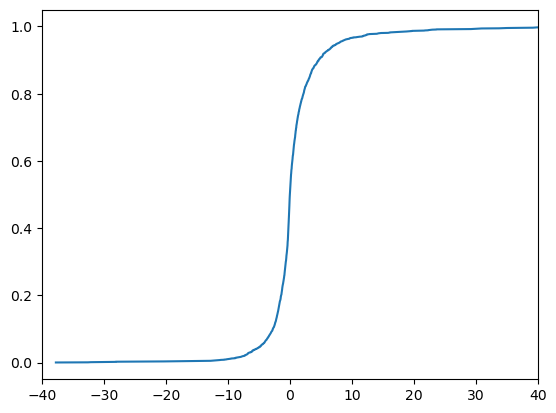

In [41]:
plt.plot(ecdf.x, ecdf.y)
plt.xlim(-40, 40)
plt.show()

To obtain the percent point function, we use interpolation to find the inverse of the ECDF above, which is acceptable since we have enough samples. scipy's `interp1d` function can be used for this purpose.

In [42]:
from scipy.interpolate import interp1d

In [43]:
eppf = interp1d(ecdf.y, ecdf.x)

We offset our predictions by eppf(critical fractile) to obtain the optimal inventory level. 

In [44]:
price = 20
cost = 12
salvage = 8
over = cost - salvage
under = price - cost
critical_fractile = under / (over + under)
critical_fractile

0.6666666666666666

### Predictions

In [45]:
output_df = test.copy()

In [46]:
output_df['sales'] = np.exp(cb_log.predict(non_standardized_X_test))
output_df.head()

,productID,brandID,attribute1,attribute2,attribute3,attribute4,clickVolume,avgOriginalUnitPrice,avgFinalUnitPrice,ma14SalesVolume,weekday,meanAge,gender,meanEducation,maritalStatus,plus,meanPurchasePower,meanUserLevel,meanCityLevel,sales
0,75,18,2.0,60.0,16,9.698610,556.0,39.9,32.505600,47.642857,5,28.947368,0.473684,3.105263,0.473684,0.428571,2.157895,2.750000,2.333333,32.661601
1,25,23,3.0,60.0,1,3.000095,1474.0,79.0,42.322917,39.285714,4,32.586667,0.200000,3.144928,0.547945,0.220930,2.287671,2.750000,2.138889,84.081865
2,17,10,4.0,100.0,2,2.975707,473.0,170.0,119.140000,50.000000,4,30.000000,0.100000,3.400000,0.777778,0.300000,2.111111,2.700000,2.666667,12.190143
3,47,18,2.0,60.0,1,6.642244,556.0,89.0,47.500000,17.857143,5,32.173913,0.347826,3.000000,0.636364,0.478261,2.190476,2.782609,2.285714,24.006259
4,91,36,3.0,60.0,4,28.889627,238.0,120.0,119.555556,4.785714,5,31.111111,0.222222,2.888889,0.666667,0.111111,2.250000,2.777778,2.222222,8.977406


### Inventory

In [47]:
output_df['inventory'] = output_df['sales'] + eppf(critical_fractile)
output_df.head()

,productID,brandID,attribute1,attribute2,attribute3,attribute4,clickVolume,avgOriginalUnitPrice,avgFinalUnitPrice,ma14SalesVolume,...,meanAge,gender,meanEducation,maritalStatus,plus,meanPurchasePower,meanUserLevel,meanCityLevel,sales,inventory
0,75,18,2.0,60.0,16,9.698610,556.0,39.9,32.505600,47.642857,...,28.947368,0.473684,3.105263,0.473684,0.428571,2.157895,2.750000,2.333333,32.661601,33.468889
1,25,23,3.0,60.0,1,3.000095,1474.0,79.0,42.322917,39.285714,...,32.586667,0.200000,3.144928,0.547945,0.220930,2.287671,2.750000,2.138889,84.081865,84.889153
2,17,10,4.0,100.0,2,2.975707,473.0,170.0,119.140000,50.000000,...,30.000000,0.100000,3.400000,0.777778,0.300000,2.111111,2.700000,2.666667,12.190143,12.997431
3,47,18,2.0,60.0,1,6.642244,556.0,89.0,47.500000,17.857143,...,32.173913,0.347826,3.000000,0.636364,0.478261,2.190476,2.782609,2.285714,24.006259,24.813547
4,91,36,3.0,60.0,4,28.889627,238.0,120.0,119.555556,4.785714,...,31.111111,0.222222,2.888889,0.666667,0.111111,2.250000,2.777778,2.222222,8.977406,9.784694


Final step is to round both sales and inventory to the nearest integer.

In [48]:
output_df['sales'] = np.round(output_df['sales'])
output_df['inventory'] = np.round(output_df['inventory'])
output_df.head()

,productID,brandID,attribute1,attribute2,attribute3,attribute4,clickVolume,avgOriginalUnitPrice,avgFinalUnitPrice,ma14SalesVolume,...,meanAge,gender,meanEducation,maritalStatus,plus,meanPurchasePower,meanUserLevel,meanCityLevel,sales,inventory
0,75,18,2.0,60.0,16,9.698610,556.0,39.9,32.505600,47.642857,...,28.947368,0.473684,3.105263,0.473684,0.428571,2.157895,2.750000,2.333333,33.0,33.0
1,25,23,3.0,60.0,1,3.000095,1474.0,79.0,42.322917,39.285714,...,32.586667,0.200000,3.144928,0.547945,0.220930,2.287671,2.750000,2.138889,84.0,85.0
2,17,10,4.0,100.0,2,2.975707,473.0,170.0,119.140000,50.000000,...,30.000000,0.100000,3.400000,0.777778,0.300000,2.111111,2.700000,2.666667,12.0,13.0
3,47,18,2.0,60.0,1,6.642244,556.0,89.0,47.500000,17.857143,...,32.173913,0.347826,3.000000,0.636364,0.478261,2.190476,2.782609,2.285714,24.0,25.0
4,91,36,3.0,60.0,4,28.889627,238.0,120.0,119.555556,4.785714,...,31.111111,0.222222,2.888889,0.666667,0.111111,2.250000,2.777778,2.222222,9.0,10.0


In [49]:
output_df.to_csv('group15.csv')